SECOND ASSIGNMENT OF ENERJISA & PATIKA BOOTCAMP
* SEPARATE AND FEATURE ENG.
  * [Import Lib & Dataframe](#1)
  * [Feature Engineering](#2)
  * [Separate DataFrame](#3)
  * [Model & Fit](#4)
  * [With Validation](#5)

****
<a name="1"></a>
#### Import Lib & Dataframe

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
import random

In [109]:
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['auto_insurance_csv.csv']))

Saving auto_insurance_csv.csv to auto_insurance_csv (3).csv


****
<a name="2"></a>
#### Feature Engineering

In [110]:
df = df.drop(['_c39','Unnamed: 0'], axis = 1)

In [111]:
df['umbrella_limit'] = df.umbrella_limit.fillna("9999")
df['police_report_available'] = df.police_report_available.fillna("MISSING")
df['policy_csl'] = df.policy_csl.fillna("MISSING")

In [112]:
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_day_of_policy'] = (df.incident_date -  df.policy_bind_date).dt.days

In [113]:
df['location_check'] = np.nan
df['location_check'] = np.where(df['policy_state'] == df['incident_state'], True, False)
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)
df['umbrella_limit'] = df.umbrella_limit.astype(str)
umbrealla = df['umbrella_limit'].unique()

In [114]:
for umb in umbrealla:
  if (umb != '0.0') & (umb != '9999'):
    df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')
    
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
  if (hobby != 'chess') & (hobby != 'cross-fit'):
    df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['age'] = df.age.fillna(9999)
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','9999']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 9999]

df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)

In [115]:
df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium'], axis = 1)

required_columns = ['incident_date','policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount','auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group']
df1 = df[required_columns]

In [116]:
df1.head()
df1.incident_date.count() #incident_date sayısı

1000

****
<a name="3"></a>
#### Separate DataFrame

In [117]:
# verilerin 200'e 800 olarak validation ve train dataseti olarak ayrılması
df1_val = df1.sort_values(by='incident_date',ascending=False).head(200) 
df2 = df1.sort_values(by='incident_date',ascending=False).tail(800)

In [118]:
df1.sort_values(by='incident_date',ascending=False) #incident_date'e göre sıralanması

,incident_date,policy_state,policy_csl,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,auto_make,auto_model,auto_year,fraud_reported,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
752,2015-03-01,IL,MISSING,0.0,441533,MALE,PhD,machine-op-inspct,other,unmarried,57100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Fire,NC,Northbend,7236 Apache Lane,2,4,YES,0,2,NO,38640,Chevrolet,Tahoe,1997,0,5718,False,9999,401-450,low,0-500
74,2015-03-01,IL,MISSING,0.0,472895,FEMALE,Associate,sales,other,wife,0,0,Multi-vehicle Collision,Side Collision,Minor Damage,Ambulance,VA,Springfield,4755 Best Lane,18,3,YES,1,0,YES,42930,BMW,X6,2005,0,3972,False,36-40,201-250,medium,501-1000
914,2015-03-01,OH,MISSING,0.0,436364,FEMALE,JD,transport-moving,cross-fit,own-child,0,-67000,Multi-vehicle Collision,Front Collision,Major Damage,Fire,NY,Riverwood,7495 Washington Ave,2,4,YES,0,2,YES,72800,Honda,Accord,1998,0,5343,False,36-40,101-150,low,1501-2000
883,2015-03-01,OH,MISSING,0.0,479824,FEMALE,Associate,exec-managerial,other,not-in-family,0,0,Multi-vehicle Collision,Side Collision,Major Damage,Ambulance,WV,Riverwood,1472 4th Drive,18,3,YES,0,3,NO,34160,Audi,A5,2005,1,3374,False,31-35,101-150,medium,501-1000
839,2015-03-01,OH,MISSING,0.0,448294,MALE,Associate,protective-serv,other,own-child,0,-48800,Single Vehicle Collision,Rear Collision,Major Damage,Police,SC,Northbrook,7197 2nd Drive,4,1,NO,2,2,MISSING,51600,Dodge,Neon,2011,0,9106,False,41-45,201-250,medium,0-500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,2015-01-01,IN,MISSING,0.0,472814,FEMALE,JD,machine-op-inspct,other,other-relative,0,0,Multi-vehicle Collision,Rear Collision,Total Loss,Police,WV,Northbend,5333 MLK Lane,3,4,NO,0,1,MISSING,67800,Ford,F150,2011,0,8397,False,26-30,101-150,high,0-500
457,2015-01-01,IL,100/300,0.0,470559,MALE,Masters,transport-moving,other,own-child,38000,-41200,Single Vehicle Collision,Side Collision,Major Damage,Ambulance,NC,Riverwood,4335 1st St,5,1,?,2,1,YES,79800,Volkswagen,Passat,2011,1,759,False,26-30,101-150,high,1501-2000
478,2015-01-01,IL,500/1000,9999,477260,MALE,Masters,armed-forces,chess,unmarried,0,0,Vehicle Theft,?,Minor Damage,Police,NC,Riverwood,1617 Rock Drive,6,1,NO,1,2,MISSING,6300,Mercedes,C300,2001,1,6130,False,51-55,401-450,low,1501-2000
41,2015-01-01,IN,250/500,0.0,470577,MALE,Associate,transport-moving,chess,unmarried,0,-24100,Single Vehicle Collision,Side Collision,Major Damage,Police,WV,Northbrook,5719 2nd Lane,1,1,?,1,1,?,97080,BMW,X5,2001,1,854,False,9999,101-150,high,0-500


In [119]:
df1_val = df1_val.drop(["incident_date"],axis=1)
df2 = df2.drop(["incident_date"],axis=1)

In [120]:
#incident_location kolonunun kaldırılması
df1_val = df1_val.drop(["incident_location"],axis=1)
df2 = df2.drop(["incident_location"],axis=1)

In [121]:
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in cat_cols:
  df2[col] = df2[col].astype('object')

columns_to_encode = []
for col in df2.columns:
  if df2[col].dtype == 'object':
    columns_to_encode.append(col)

columns_to_encode

['policy_state',
 'policy_csl',
 'umbrella_limit',
 'insured_sex',
 'insured_education_level',
 'insured_occupation',
 'insured_hobbies',
 'insured_relationship',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'incident_state',
 'incident_city',
 'property_damage',
 'police_report_available',
 'auto_make',
 'auto_model',
 'location_check',
 'age_group',
 'months_as_customer_groups',
 'policy_annual_premium_groups',
 'policy_deductable_group']

In [122]:
df2["policy_deductable_group"].value_counts()

501-1000     279
0-500        270
1501-2000    251
Name: policy_deductable_group, dtype: int64

In [123]:
dfohe = pd.get_dummies(df2, columns = columns_to_encode)
cl=[]
for _ in dfohe.columns:
    cl.append(_)
cl

['insured_zip',
 'capital-gains',
 'capital-loss',
 'incident_hour_of_the_day',
 'number_of_vehicles_involved',
 'bodily_injuries',
 'witnesses',
 'total_claim_amount',
 'auto_year',
 'fraud_reported',
 'claim_day_of_policy',
 'policy_state_IL',
 'policy_state_IN',
 'policy_state_OH',
 'policy_csl_100/300',
 'policy_csl_250/500',
 'policy_csl_500/1000',
 'policy_csl_MISSING',
 'umbrella_limit_0.0',
 'umbrella_limit_9999',
 'umbrella_limit_other',
 'insured_sex_FEMALE',
 'insured_sex_MALE',
 'insured_education_level_Associate',
 'insured_education_level_College',
 'insured_education_level_High School',
 'insured_education_level_JD',
 'insured_education_level_MD',
 'insured_education_level_Masters',
 'insured_education_level_PhD',
 'insured_occupation_adm-clerical',
 'insured_occupation_armed-forces',
 'insured_occupation_craft-repair',
 'insured_occupation_exec-managerial',
 'insured_occupation_farming-fishing',
 'insured_occupation_handlers-cleaners',
 'insured_occupation_machine-op-in

In [124]:
df_10 = dfohe.iloc[:,:11]
cl1= cl[11:]
cl1

['policy_state_IL',
 'policy_state_IN',
 'policy_state_OH',
 'policy_csl_100/300',
 'policy_csl_250/500',
 'policy_csl_500/1000',
 'policy_csl_MISSING',
 'umbrella_limit_0.0',
 'umbrella_limit_9999',
 'umbrella_limit_other',
 'insured_sex_FEMALE',
 'insured_sex_MALE',
 'insured_education_level_Associate',
 'insured_education_level_College',
 'insured_education_level_High School',
 'insured_education_level_JD',
 'insured_education_level_MD',
 'insured_education_level_Masters',
 'insured_education_level_PhD',
 'insured_occupation_adm-clerical',
 'insured_occupation_armed-forces',
 'insured_occupation_craft-repair',
 'insured_occupation_exec-managerial',
 'insured_occupation_farming-fishing',
 'insured_occupation_handlers-cleaners',
 'insured_occupation_machine-op-inspct',
 'insured_occupation_other-service',
 'insured_occupation_priv-house-serv',
 'insured_occupation_prof-specialty',
 'insured_occupation_protective-serv',
 'insured_occupation_sales',
 'insured_occupation_tech-support',
 

In [125]:
df_10.head(20)

,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,auto_year,fraud_reported,claim_day_of_policy
511,446755,0,-46200,9,1,2,3,6560,2003,0,4427
894,475891,0,0,6,1,1,3,6000,2000,0,8921
125,603948,47200,-69700,12,3,2,3,36300,2013,0,205
895,462525,26500,0,23,3,0,3,55200,1998,1,1980
485,471366,0,-31700,0,1,2,1,48290,1995,0,7692
398,604328,0,-47400,7,1,0,1,3190,2015,0,8231
295,438546,0,-54600,13,1,1,2,72120,2009,0,3483
542,431354,0,0,21,3,1,3,48070,2014,0,2591
285,476737,0,-40900,8,1,0,1,70290,2008,0,6798
858,437470,0,0,17,3,2,3,42500,2000,0,5385


In [126]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
df3=ohe.fit_transform(df2[columns_to_encode]).toarray()

In [127]:
df_10.reset_index(drop=True, inplace=True)

In [128]:
df4=pd.DataFrame(df3, columns=cl1)
df5 = pd.concat([df_10,df4], axis=1)
df5.head(14)

,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,auto_year,fraud_reported,claim_day_of_policy,policy_state_IL,policy_state_IN,policy_state_OH,policy_csl_100/300,policy_csl_250/500,policy_csl_500/1000,policy_csl_MISSING,umbrella_limit_0.0,umbrella_limit_9999,umbrella_limit_other,insured_sex_FEMALE,insured_sex_MALE,insured_education_level_Associate,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,insured_occupation_adm-clerical,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,...,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,location_check_False,location_check_True,age_group_15-20,age_group_21-25,age_group_26-30,age_group_31-35,age_group_36-40,age_group_41-45,age_group_46-50,age_group_51-55,age_group_56-60,age_group_61-65,age_group_9999,months_as_customer_groups_0-50,months_as_customer_groups_101-150,months_as_customer_groups_151-200,months_as_customer_groups_201-250,months_as_customer_groups_251-300,months_as_customer_groups_301-350,months_as_customer_groups_351-400,months_as_customer_groups_401-450,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low,policy_deductable_group_0-500,policy_deductable_group_1501-2000,policy_deductable_group_501-1000
0,446755,0,-46200,9,1,2,3,6560,2003,0,4427,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,475891,0,0,6,1,1,3,6000,2000,0,8921,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,603948,47200,-69700,12,3,2,3,36300,2013,0,205,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,462525,26500,0,23,3,0,3,55200,1998,1,1980,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,471366,0,-31700,0,1,2,1,48290,1995,0,7692,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,604328,0,-47400,7,1,0,1,3190,2015,0,8231,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
6,438546,0,-54600,13,1,1,2,72120,2009,0,3483,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,

****
<a name="4"></a>
#### Model & Fit

In [129]:
features = []
for col in df5.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X = df5[features]
y = df5[target]

In [130]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

In [131]:
X

array([[-0.76745023, -0.90867046, -0.68250677, ..., -0.71374643,
        -0.67616189,  1.36652242],
       [-0.36042417, -0.90867046,  0.96145549, ...,  1.4010578 ,
        -0.67616189, -0.73178456],
       [ 1.42851515,  0.79450874, -1.51872134, ..., -0.71374643,
        -0.67616189,  1.36652242],
       ...,
       [-0.34129942, -0.90867046,  0.96145549, ..., -0.71374643,
         1.47893576, -0.73178456],
       [-0.43466004, -0.90867046,  0.10389076, ...,  1.4010578 ,
        -0.67616189, -0.73178456],
       [ 1.55253963,  0.97493027,  0.96145549, ...,  1.4010578 ,
        -0.67616189, -0.73178456]])

In [132]:
oversample = SMOTE(random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



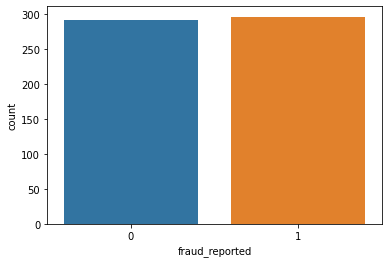

In [133]:
chck = pd.DataFrame()
chck['fraud_reported'] = y_train

sns.countplot(chck['fraud_reported'])

93.25396825396825

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       128
           1       0.92      0.94      0.93       124

    accuracy                           0.93       252
   macro avg       0.93      0.93      0.93       252
weighted avg       0.93      0.93      0.93       252



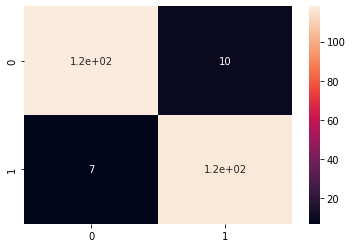

In [134]:
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

In [135]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

{'n_estimators': [300, 650, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 17, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [136]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 300}

93.25396825396825

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       128
           1       0.91      0.96      0.93       124

    accuracy                           0.93       252
   macro avg       0.93      0.93      0.93       252
weighted avg       0.93      0.93      0.93       252



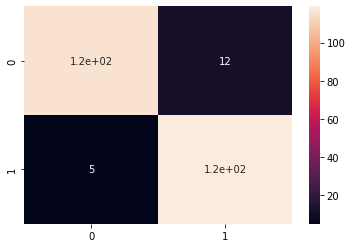

In [137]:
rf2 = RandomForestClassifier(n_estimators=300,min_samples_split=5,min_samples_leaf=1,max_features='sqrt'
                            ,max_depth=5,bootstrap='False')
rf2.fit(X_train, y_train)

preds = rf2.predict(X_test)

score = rf2.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

****
<a name="5"></a>
### With Validation

In [138]:
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in cat_cols:
  df1_val[col] = df1_val[col].astype('object')

columns_to_encode = []
for col in df1_val.columns:
  if df1_val[col].dtype == 'object':
    columns_to_encode.append(col)

df2_val = pd.DataFrame(ohe.transform(df1_val[columns_to_encode]).toarray(), columns=cl1)

In [139]:
df2_val.head()

,policy_state_IL,policy_state_IN,policy_state_OH,policy_csl_100/300,policy_csl_250/500,policy_csl_500/1000,policy_csl_MISSING,umbrella_limit_0.0,umbrella_limit_9999,umbrella_limit_other,insured_sex_FEMALE,insured_sex_MALE,insured_education_level_Associate,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,insured_occupation_adm-clerical,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,insured_occupation_protective-serv,insured_occupation_sales,insured_occupation_tech-support,insured_occupation_transport-moving,insured_hobbies_chess,insured_hobbies_cross-fit,insured_hobbies_other,insured_relationship_husband,insured_relationship_not-in-family,insured_relationship_other-relative,insured_relationship_own-child,...,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,location_check_False,location_check_True,age_group_15-20,age_group_21-25,age_group_26-30,age_group_31-35,age_group_36-40,age_group_41-45,age_group_46-50,age_group_51-55,age_group_56-60,age_group_61-65,age_group_9999,months_as_customer_groups_0-50,months_as_customer_groups_101-150,months_as_customer_groups_151-200,months_as_customer_groups_201-250,months_as_customer_groups_251-300,months_as_customer_groups_301-350,months_as_customer_groups_351-400,months_as_customer_groups_401-450,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low,policy_deductable_group_0-500,policy_deductable_group_1501-2000,policy_deductable_group_501-1000
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [140]:
cl0 = cl[:11] # Sayısal kolonlar
df_val_num = pd.DataFrame(df1_val, columns=cl0)

In [141]:
df_val_num.reset_index(drop=True, inplace=True)

In [142]:
df3_val = pd.concat([df_val_num,df2_val], axis=1)
df3_val.head()

,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,auto_year,fraud_reported,claim_day_of_policy,policy_state_IL,policy_state_IN,policy_state_OH,policy_csl_100/300,policy_csl_250/500,policy_csl_500/1000,policy_csl_MISSING,umbrella_limit_0.0,umbrella_limit_9999,umbrella_limit_other,insured_sex_FEMALE,insured_sex_MALE,insured_education_level_Associate,insured_education_level_College,insured_education_level_High School,insured_education_level_JD,insured_education_level_MD,insured_education_level_Masters,insured_education_level_PhD,insured_occupation_adm-clerical,insured_occupation_armed-forces,insured_occupation_craft-repair,insured_occupation_exec-managerial,insured_occupation_farming-fishing,insured_occupation_handlers-cleaners,insured_occupation_machine-op-inspct,insured_occupation_other-service,insured_occupation_priv-house-serv,insured_occupation_prof-specialty,...,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,location_check_False,location_check_True,age_group_15-20,age_group_21-25,age_group_26-30,age_group_31-35,age_group_36-40,age_group_41-45,age_group_46-50,age_group_51-55,age_group_56-60,age_group_61-65,age_group_9999,months_as_customer_groups_0-50,months_as_customer_groups_101-150,months_as_customer_groups_151-200,months_as_customer_groups_201-250,months_as_customer_groups_251-300,months_as_customer_groups_301-350,months_as_customer_groups_351-400,months_as_customer_groups_401-450,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low,policy_deductable_group_0-500,policy_deductable_group_1501-2000,policy_deductable_group_501-1000
0,441533,57100,0,2,4,0,2,38640,1997,0,5718,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,472895,0,0,18,3,1,0,42930,2005,0,3972,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,436364,0,-67000,2,4,0,2,72800,1998,0,5343,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,479824,0,0,18,3,0,3,34160,2005,1,3374,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,448294,0,-48800,4,1,2,2,51600,2011,0,9106,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [143]:
features = []
for col in df3_val.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X_val = df3_val[features]
y_val = df3_val[target]

****
#### Random Forest Classifier

In [162]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_val = sc.fit_transform(X_val)

In [163]:

X

array([[-0.76745023, -0.90867046, -0.68250677, ..., -0.71374643,
        -0.67616189,  1.36652242],
       [-0.36042417, -0.90867046,  0.96145549, ...,  1.4010578 ,
        -0.67616189, -0.73178456],
       [ 1.42851515,  0.79450874, -1.51872134, ..., -0.71374643,
        -0.67616189,  1.36652242],
       ...,
       [-0.34129942, -0.90867046,  0.96145549, ..., -0.71374643,
         1.47893576, -0.73178456],
       [-0.43466004, -0.90867046,  0.10389076, ...,  1.4010578 ,
        -0.67616189, -0.73178456],
       [ 1.55253963,  0.97493027,  0.96145549, ...,  1.4010578 ,
        -0.67616189, -0.73178456]])

45.0

              precision    recall  f1-score   support

           0       0.89      0.57      0.70       163
           1       0.27      0.70      0.39        37

    accuracy                           0.59       200
   macro avg       0.58      0.64      0.54       200
weighted avg       0.78      0.59      0.64       200



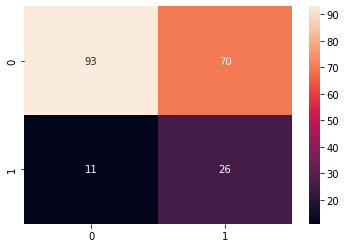

In [164]:
preds = rf2.predict(X_val)
score = rf2.score(X_val, y_val)


threshold = 0.65

preds = rf2.predict_proba(X_val)
preds = (preds[:,1] >= threshold).astype('int')
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

****
#### SVC

In [86]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

In [87]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

svc_train_acc = accuracy_score(y_train, svc.predict(X_train))
svc_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Support Vector Classifier is : {svc_train_acc}")
print(f"Test accuracy of Support Vector Classifier is : {svc_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of Support Vector Classifier is : 0.9880952380952381
Test accuracy of Support Vector Classifier is : 0.9444444444444444
[[119   9]
 [  5 119]]
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       128
           1       0.93      0.96      0.94       124

    accuracy                           0.94       252
   macro avg       0.94      0.94      0.94       252
weighted avg       0.94      0.94      0.94       252



In [88]:
y_pred_val = svc.predict(X_val)

svc_train_acc = accuracy_score(y_train, svc.predict(X_train))
svc_val_acc = accuracy_score(y_val, y_pred_val)

print(f"Training accuracy of Support Vector Classifier is : {svc_train_acc}")
print(f"Validation accuracy of Support Vector Classifier is : {svc_val_acc}")

print(confusion_matrix(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

Training accuracy of Support Vector Classifier is : 0.9880952380952381
Validation accuracy of Support Vector Classifier is : 0.78
[[134  29]
 [ 15  22]]
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       163
           1       0.43      0.59      0.50        37

    accuracy                           0.78       200
   macro avg       0.67      0.71      0.68       200
weighted avg       0.81      0.78      0.79       200



****
#### KNN

In [89]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [90]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

knn_train_acc = accuracy_score(y_train, knn.predict(X_train))
knn_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of KNN is : {knn_train_acc}")
print(f"Test accuracy of KNN is : {knn_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of KNN is : 0.5374149659863946
Test accuracy of KNN is : 0.5158730158730159
[[  6 122]
 [  0 124]]
              precision    recall  f1-score   support

           0       1.00      0.05      0.09       128
           1       0.50      1.00      0.67       124

    accuracy                           0.52       252
   macro avg       0.75      0.52      0.38       252
weighted avg       0.76      0.52      0.38       252



****
#### Decision Tree

In [91]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

In [92]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

dtc_train_acc = accuracy_score(y_train, dtc.predict(X_train))
dtc_test_acc = accuracy_score(y_test, y_pred)

print(f"Training accuracy of Decision Tree is : {dtc_train_acc}")
print(f"Test accuracy of Decision Tree is : {dtc_test_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Training accuracy of Decision Tree is : 1.0
Test accuracy of Decision Tree is : 0.873015873015873
[[114  14]
 [ 18 106]]
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       128
           1       0.88      0.85      0.87       124

    accuracy                           0.87       252
   macro avg       0.87      0.87      0.87       252
weighted avg       0.87      0.87      0.87       252



In [93]:
y_pred_val = dtc.predict(X_val)

dtc_train_acc = accuracy_score(y_train, dtc.predict(X_train))
dtc_val_acc = accuracy_score(y_val, y_pred_val)

print(f"Training accuracy of Decision Tree is : {dtc_train_acc}")
print(f"Test accuracy of Decision Tree is : {dtc_val_acc}")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_val, y_pred_val))

Training accuracy of Decision Tree is : 1.0
Test accuracy of Decision Tree is : 0.365
[[114  14]
 [ 18 106]]
              precision    recall  f1-score   support

           0       0.82      0.28      0.42       163
           1       0.19      0.73      0.30        37

    accuracy                           0.36       200
   macro avg       0.50      0.51      0.36       200
weighted avg       0.70      0.36      0.40       200



****